In [1]:
import torch
from torch import nn, optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import tarfile
from PIL import Image
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tqdm.notebook import tqdm
from itertools import chain
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [3]:
predtrained_vgg = models.vgg19_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


In [4]:
class My_Detector(nn.Module):
    def __init__(self, n_classes=1, n_coords=4):
        super(My_Detector, self).__init__()

        self.backbone = predtrained_vgg.features
        
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        self.neck = predtrained_vgg.classifier[:6]
        
        self.head_classifier = nn.Linear(4096, n_classes)
        self.head_coords_regressors = nn.Linear(4096, n_coords)

    def forward(self, x):
        x = self.backbone(x)
        x = self.avgpool(x)
        x = x.flatten(1)
        x = self.neck(x)
        label = self.head_classifier(x)
        bbox = self.head_coords_regressors(x)
        return label, bbox

In [5]:
class MultiTaskLoss(nn.Module):
    def __init__(self, weight=None, alpha=50):
        super(MultiTaskLoss, self).__init__()

        self.classifier_loss = nn.CrossEntropyLoss(weight)
        self.regressor_loss = nn.MSELoss()
        self.alpha = alpha #Будем как можно сильнее штрафовать модель за ее регрессионную компоненту, 
                           #чтобы она училась как можно точнее предсказывать все 4 координаты


    def forward(self, input, target, input_bboxes, target_bboxes):
        clf_loss = self.classifier_loss(input, target)
        reg_loss = self.regressor_loss(input_bboxes, target_bboxes)
        return clf_loss + self.alpha*reg_loss

In [6]:
class Cats_Dogs_Dataset(Dataset):
    def __init__(self, files):
        super().__init__()
        self.files = files
        self.len_ = len(self.files)
                      
    def __len__(self):
        return self.len_
  
    def __getitem__(self, index):
        to_tensor = transforms.ToTensor()
        transform = transforms.Compose([
                                        transforms.Resize((220, 220)),
                                        transforms.Normalize([0.485, 0.456, 0.406],
                                                             [0.229, 0.224, 0.225])])
        image = Image.open(self.files[index][0])
        width = image.width
        height = image.height
        scales = [width, height]*2
        label_bbox = open(self.files[index][1], 'r').read()
        label = torch.tensor(int(label_bbox[:1]) - 1).long()
        bbox = torch.tensor([int(number)/scale for number, scale 
                         in zip(label_bbox[1:].split(), scales)])
        image = to_tensor(image)
        if image.shape[0] == 1:
            image = image.repeat((3, 1, 1))
        image = transform(image)
        return image, label, bbox

In [7]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, device, sched=None):
    model.to(device)
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        loss_sum = 0
        for xb, yb, bboxes in tqdm(train_dl):
            xb, yb, bboxes = xb.to(device), yb.to(device), bboxes.to(device)
            y_pred,  pred_bboxes = model(xb)
            loss = loss_func(y_pred, yb, pred_bboxes, bboxes)
            loss_sum += loss.item()
            
            loss.backward()
            opt.step()
            opt.zero_grad()
        train_losses.append(loss_sum / len(train_dl))

        model.eval()
        loss_sum = 0
        with torch.no_grad():
            for xb, yb, bboxes in valid_dl:
                xb, yb, bboxes = xb.to(device), yb.to(device), bboxes.to(device)
                y_pred,  pred_bboxes = model(xb)
                loss = loss_func(y_pred, yb, pred_bboxes, bboxes)
                loss_sum += loss.item()  
        val_losses.append(loss_sum / len(valid_dl))
        
        if sched is not None:
            sched.step()

        print(f'epoch {epoch + 1}:')
        print(f'train loss = {train_losses[epoch]:.5f} | valid loss = {val_losses[epoch]:.5f}', '\n')

    return train_losses, val_losses

In [8]:
def plot_trainig(train_losses, valid_losses):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(16, 6))
    plt.xlabel('epoch')
    plt.plot(epochs, train_losses, label='train_loss')
    plt.plot(epochs, valid_losses, label='valid_loss')
    plt.legend()
    plt.grid(True)

In [9]:
def predict(model, loader):
    with torch.no_grad():
        logits = []
    
        for inputs, label, bbox in loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs)[0]
            logits.append(outputs.cpu())
            
    preds = torch.cat(logits)
    return preds.softmax(-1).detach().numpy().argmax(1)#, logits

In [10]:
def predict_proba(model, loader):
    with torch.no_grad():
        logits = []
    
        for inputs, label, bbox in loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs)[0]
            logits.append(outputs.cpu())
            
    preds = torch.cat(logits)
    return preds.softmax(-1).detach().numpy().max(1)

In [11]:
def predict_bbox(model, loader):
    with torch.no_grad():
        logits = []
    
        for inputs, label, bbox in loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs)[1]
            logits.append(outputs.cpu())
            
    bboxes = torch.cat(logits)
    return bboxes.detach().numpy()

In [12]:
def extract_bbox(loader):
    logits = []
    for inputs, label, bbox in loader:
      logits.append(bbox)
            
    bboxes = torch.cat(logits)
    return bboxes.detach().numpy()

In [13]:
def calculate_IoU(bboxA, bboxB):
    xA = max(bboxA[0], bboxB[0])
    yA = max(bboxA[1], bboxB[1])
    xB = min(bboxA[2], bboxB[2])
    yB = min(bboxA[3], bboxB[3])
    interArea = abs(max(0, xB - xA) * max(0, yB - yA))
    bboxAArea = abs((bboxA[2] - bboxA[0]) * (bboxA[3] - bboxA[1]))
    bboxBArea = abs((bboxB[2] - bboxB[0]) * (bboxB[3] - bboxB[1]))
    iou = interArea / (bboxAArea + bboxBArea - interArea)
    return iou


In [14]:
def imshow(input_tensor, title, bbox, pred=None, plt_ax=plt):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    scale = 220
    image = input_tensor.permute(1, 2, 0).numpy()
    image = image * std + mean
    image = np.clip(image, 0, 1)
    xmin, ymin, xmax, ymax = bbox * scale
    plt_ax.imshow(image)
    plt_ax.set_title(title)
    plt_ax.axis('off')
    plt_ax.hlines(ymin, xmin, xmax, colors='aqua', label='True')
    plt_ax.hlines(ymax, xmin, xmax, colors='aqua')
    plt_ax.vlines(xmin, ymin, ymax, colors='aqua')
    plt_ax.vlines(xmax, ymin, ymax, colors='aqua')
    if pred is not None:
        pred_title, pred_bbox, proba, IoU = pred
        pred_xmin, pred_ymin, pred_xmax, pred_ymax = pred_bbox * scale
        plt_ax.hlines(pred_ymin, pred_xmin, pred_xmax, colors='lime', label='Predicted')
        plt_ax.hlines(pred_ymax, pred_xmin, pred_xmax, colors='lime')
        plt_ax.vlines(pred_xmin, pred_ymin, pred_ymax, colors='lime')
        plt_ax.vlines(pred_xmax, pred_ymin, pred_ymax, colors='lime')
        box = {'facecolor':'gray',   'alpha' : 0.3}
        plt_ax.text(pred_xmin, pred_ymin, pred_title + f' {proba * 100 :.0f}% IoU = {IoU * 100 :.0f}%', bbox=box)
        plt_ax.legend(loc='lower right')

In [15]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [16]:
with tarfile.open('/content/gdrive/My Drive/ML/cats_dogs_dataset.tar', 'r') as tar:
    tar.extractall(path = './Cats and dogs')

In [17]:
DIR = Path('./Cats and dogs')

train_val_files = list(zip(sorted(list(DIR.rglob('*.jpg'))), sorted(list(DIR.rglob('*.txt')))))

In [18]:
train_val_labels = [int(open(files[1], 'r').read()[:1]) - 1 for files in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=385, 
                                          stratify=train_val_labels, random_state=42)

y_train = [int(open(files[1], 'r').read()[:1]) - 1 for files in train_files]
y_val = [int(open(files[1], 'r').read()[:1]) - 1 for files in val_files]

weight = torch.FloatTensor(compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)).to(DEVICE)

In [19]:
train_dataset = Cats_Dogs_Dataset(train_files)
val_dataset = Cats_Dogs_Dataset(val_files)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=64)

classes = ['Cat', 'Dog']

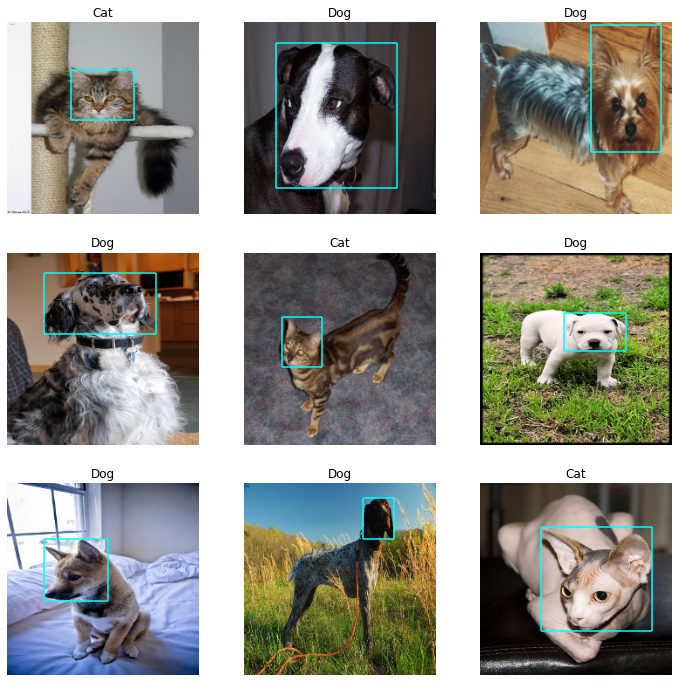

In [20]:
np.random.seed(3)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_characters = np.random.randint(0, len(val_dataset))
    img_val, label, bbox = val_dataset[random_characters]
    img_label = classes[label]
    imshow(img_val, img_label, bbox, plt_ax=fig_x)

In [21]:
torch.manual_seed(42)

model = My_Detector(n_classes=2)
optimizer = torch.optim.Adam(
    (
        {
            'params': chain(model.backbone.parameters(), model.neck.parameters()),
            'lr': 1e-4,
        },
        {
            'params': chain(
                            model.head_classifier.parameters(), 
                            model.head_coords_regressors.parameters()),
        }
     ),
     lr=1e-2
)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.67)
criterion = MultiTaskLoss(weight)


epoch 1:
train loss = 51.76072 | valid loss = 2.39788 




epoch 2:
train loss = 2.75901 | valid loss = 1.98294 




epoch 3:
train loss = 2.14503 | valid loss = 1.39733 




epoch 4:
train loss = 1.67740 | valid loss = 0.84533 




epoch 5:
train loss = 1.32449 | valid loss = 0.66268 




epoch 6:
train loss = 1.10125 | valid loss = 0.55934 




epoch 7:
train loss = 0.93950 | valid loss = 0.44870 




epoch 8:
train loss = 0.83697 | valid loss = 0.37061 




epoch 9:
train loss = 0.74522 | valid loss = 0.38500 




epoch 10:
train loss = 0.69125 | valid loss = 0.32585 




epoch 11:
train loss = 0.60204 | valid loss = 0.29945 




epoch 12:
train loss = 0.56543 | valid loss = 0.27744 




epoch 13:
train loss = 0.52825 | valid loss = 0.29938 




epoch 14:
train loss = 0.51242 | valid loss = 0.26469 




epoch 15:
train loss = 0.50186 | valid loss = 0.25281 




epoch 16:
train loss = 0.46319 | valid loss = 0.25384 




epoch 17:
train loss = 0.43871 | valid loss = 0.24529 




epoch 18:
train loss = 0.42326 | valid loss = 0.23985 




epoch 19:
train loss = 0.42494 | valid loss = 0.22736 




epoch 20:
train loss = 0.39491 | valid loss = 0.22681 




epoch 21:
train loss = 0.38353 | valid loss = 0.21982 




epoch 22:
train loss = 0.37632 | valid loss = 0.22824 




epoch 23:
train loss = 0.37078 | valid loss = 0.21342 




epoch 24:
train loss = 0.36228 | valid loss = 0.20671 




epoch 25:
train loss = 0.36257 | valid loss = 0.22166 



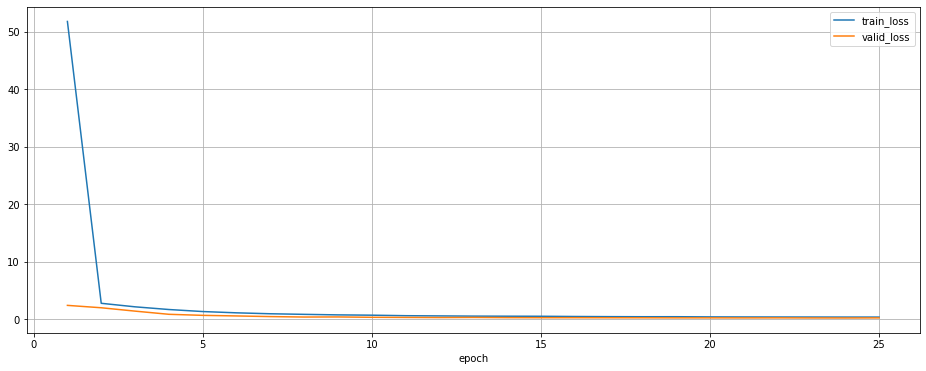

In [22]:
plot_trainig(*fit(25, model, criterion, optimizer, train_dataloader, val_dataloader, DEVICE, scheduler))

In [23]:
optimizer = torch.optim.Adam(
    (
        {
            'params': chain(model.backbone.parameters(), model.neck.parameters()),
            'lr': 1e-4,
        },
        {
            'params': chain(
                            model.head_classifier.parameters(), 
                            model.head_coords_regressors.parameters()),
        }
     ),
     lr=1e-2
)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.67)


epoch 1:
train loss = 0.74474 | valid loss = 0.23444 




epoch 2:
train loss = 0.38942 | valid loss = 0.22685 




epoch 3:
train loss = 0.32253 | valid loss = 0.13505 




epoch 4:
train loss = 0.26745 | valid loss = 0.16050 




epoch 5:
train loss = 0.23540 | valid loss = 0.14478 




epoch 6:
train loss = 0.21153 | valid loss = 0.14884 




epoch 7:
train loss = 0.20614 | valid loss = 0.12080 




epoch 8:
train loss = 0.17155 | valid loss = 0.12074 




epoch 9:
train loss = 0.17162 | valid loss = 0.11223 




epoch 10:
train loss = 0.15008 | valid loss = 0.10227 




epoch 11:
train loss = 0.13826 | valid loss = 0.09134 




epoch 12:
train loss = 0.13552 | valid loss = 0.09814 




epoch 13:
train loss = 0.12184 | valid loss = 0.09354 




epoch 14:
train loss = 0.11653 | valid loss = 0.08864 




epoch 15:
train loss = 0.10663 | valid loss = 0.07215 




epoch 16:
train loss = 0.10382 | valid loss = 0.07359 




epoch 17:
train loss = 0.09828 | valid loss = 0.08367 




epoch 18:
train loss = 0.10027 | valid loss = 0.09816 




epoch 19:
train loss = 0.09411 | valid loss = 0.07893 




epoch 20:
train loss = 0.08691 | valid loss = 0.07677 




epoch 21:
train loss = 0.08288 | valid loss = 0.07174 




epoch 22:
train loss = 0.07884 | valid loss = 0.06921 




epoch 23:
train loss = 0.07793 | valid loss = 0.06624 




epoch 24:
train loss = 0.07715 | valid loss = 0.06947 




epoch 25:
train loss = 0.07096 | valid loss = 0.06485 




epoch 26:
train loss = 0.06790 | valid loss = 0.06775 




epoch 27:
train loss = 0.06783 | valid loss = 0.06643 




epoch 28:
train loss = 0.06646 | valid loss = 0.07092 




epoch 29:
train loss = 0.06626 | valid loss = 0.06591 




epoch 30:
train loss = 0.06563 | valid loss = 0.06887 




epoch 31:
train loss = 0.06284 | valid loss = 0.06475 



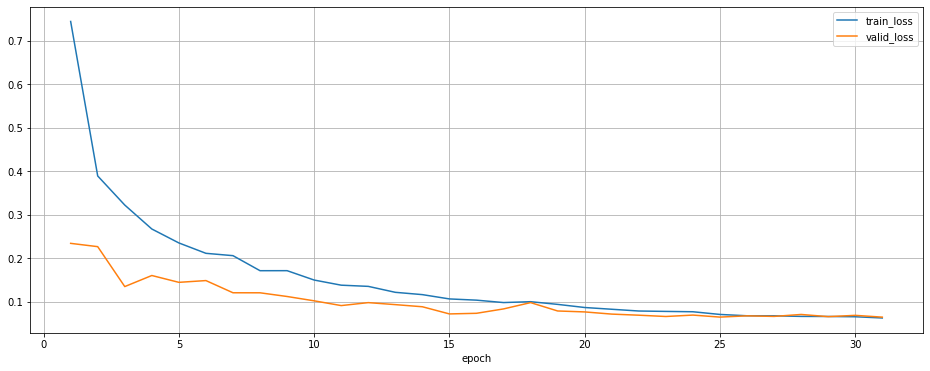

In [24]:
plot_trainig(*fit(31, model, criterion, optimizer, train_dataloader, val_dataloader, DEVICE, scheduler))

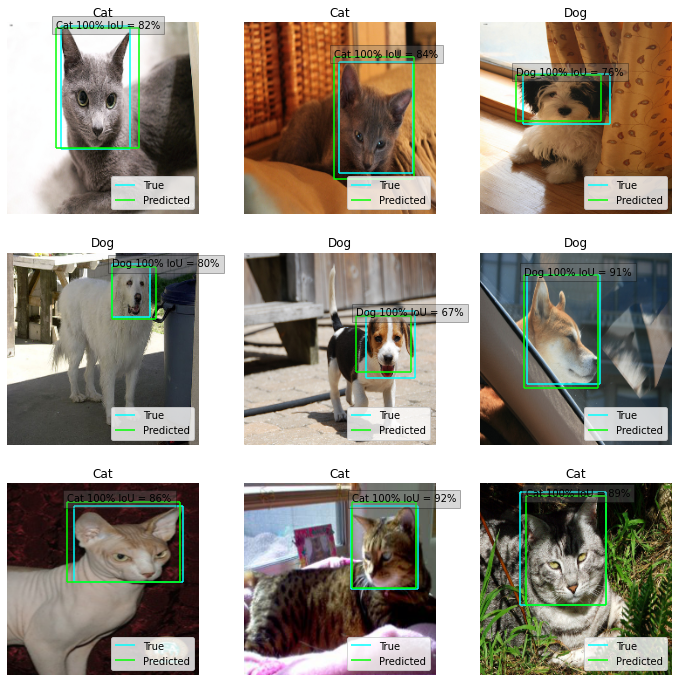

In [25]:
np.random.seed(66)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_characters = np.random.randint(0, len(val_dataset))
    img_data = val_dataset[random_characters]
    img_dl = DataLoader([img_data])
    img_val, label, bbox = img_data
    img_label = classes[label]
    pred_label = predict(model, img_dl).squeeze()
    pred_bbox = predict_bbox(model, img_dl).squeeze()
    proba = predict_proba(model, img_dl).squeeze()
    pred_img_label = classes[pred_label]
    IoU = calculate_IoU(pred_bbox, bbox)
    pred = [pred_img_label, pred_bbox, proba, IoU]
    imshow(img_val, img_label, bbox, pred, plt_ax=fig_x)

In [26]:
true_bboxes = extract_bbox(val_dataloader)
predicted_bboxes = predict_bbox(model, val_dataloader)
mIoU = np.mean([calculate_IoU(true_bbox, predicted_bbox) for true_bbox, predicted_bbox in zip(true_bboxes, predicted_bboxes)])

y_pred = predict(model, val_dataloader)
accuracy = accuracy_score(y_val, y_pred)

time1 = pd.Timestamp.now()
with torch.no_grad():
    for image, label, bbox in img_dl:
        inputs = image.to(DEVICE)
        model.eval()
        outputs = model(inputs)
time2 = pd.Timestamp.now()
delta_time = (time2 - time1).microseconds / 1000

len_train = len(train_dataset)
len_val = len(val_dataset)

message = f'mIoU {mIoU * 100 :.0f}%, classification accuracy {accuracy * 100 :.0f}%, {delta_time}ms, {len_train} train, {len_val} valid.'
with open('/content/gdrive/My Drive/ML/results.txt', 'w') as f:
    f.write(message)

In [27]:
!cat /content/gdrive/My\ Drive/ML/results.txt

mIoU 76%, classification accuracy 100%, 3.703ms, 3000 train, 385 valid.